## Série histórica IBOVESPA

Análise preditiva da IBOVESPA

**Datasets:** http://www.bmfbovespa.com.br/pt_br/servicos/market-data/historico/mercado-a-vista/series-historicas/

**By:** Gabriel Machado Lopes Gonçalves (GMLG)

In [78]:
# Packages

from pyspark.sql.functions import substring
from pyspark.sql import Row
import pandas as pd
from datetime import datetime
import numpy as np

# Visualization
#import plotly.plotly as py
#import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Statistic
import statsmodels.api as sm

# Machine Learning
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import r2_score


# Correlation graph
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
init_notebook_mode(connected=True)

In [3]:
# Spark Context instance

print(sc)

<SparkContext master=local[*] appName=PySparkShell>


In [4]:
# read txt

ibov_v1 = sc.textFile('datasets/COTAHIST_A2018.TXT')

In [5]:
# Clean header line

header = ibov_v1.first()
ibov_v2 = ibov_v1.filter(lambda line: line != header)

In [6]:
# Split lines

ibov_v3 = ibov_v2.map(lambda x: x.split("\t"))

In [7]:
# Convert to dataframe 

ibov_v4 = spark.createDataFrame(ibov_v3)

In [8]:
# Split na linha tranformando nas colunas do dataframe
# Obs.: Falta terminar de realizar a coleta das outras colunas. 

ibov_v5 = ibov_v4.select(substring(ibov_v4[0], 1, 2).alias('TIPREG'), 
                         substring(ibov_v4[0], 3, 8).alias('DT_PREGAO'), 
                         substring(ibov_v4[0], 11, 2).alias('CODBDI'), 
                         substring(ibov_v4[0], 13, 12).alias('CODNEG'), 
                         substring(ibov_v4[0], 25, 27).alias('TPMERC'), 
                         substring(ibov_v4[0], 28, 12).alias('NOMRES'), 
                         substring(ibov_v4[0], 40, 10).alias('ESPECI'), 
                         substring(ibov_v4[0], 53, 4).alias('MODREF'),
                         substring(ibov_v4[0], 57, 13).alias('PREABE'), # Preco de abertura
                         substring(ibov_v4[0], 70, 13).alias('PREMAX'), # Preco maximo
                         substring(ibov_v4[0], 83, 13).alias('PREMIN'), 
                         substring(ibov_v4[0], 96, 13).alias('PREMED'),
                         substring(ibov_v4[0], 109, 13).alias('PREULT'),
                         substring(ibov_v4[0], 122, 13).alias('PREOFC'),
                         substring(ibov_v4[0], 135, 13).alias('PREOFV'), 
                         substring(ibov_v4[0], 148, 5).alias('TOTNEG'), 
                         substring(ibov_v4[0], 153, 18).alias('QUATOT'), 
                         substring(ibov_v4[0], 171, 16).alias('VOLTOT'), 
                         substring(ibov_v4[0], 189, 11).alias('PREEXE'), 
                         substring(ibov_v4[0], 202, 1).alias('INDOPC'), 
                         substring(ibov_v4[0], 203, 8).alias('DATVEN'), 
                         substring(ibov_v4[0], 211, 7).alias('FATCOT'), 
                         substring(ibov_v4[0], 218, 7).alias('PTOEXE'), 
                         substring(ibov_v4[0], 231, 12).alias('CODISI'), 
                         substring(ibov_v4[0], 243, 3).alias('DISMES')
                        ) 

In [10]:
# Schema

ibov_v5.printSchema()

root
 |-- TIPREG: string (nullable = true)
 |-- DT_PREGAO: string (nullable = true)
 |-- CODBDI: string (nullable = true)
 |-- CODNEG: string (nullable = true)
 |-- TPMERC: string (nullable = true)
 |-- NOMRES: string (nullable = true)
 |-- ESPECI: string (nullable = true)
 |-- MODREF: string (nullable = true)
 |-- PREABE: string (nullable = true)
 |-- PREMAX: string (nullable = true)
 |-- PREMIN: string (nullable = true)
 |-- PREMED: string (nullable = true)
 |-- PREULT: string (nullable = true)
 |-- PREOFC: string (nullable = true)
 |-- PREOFV: string (nullable = true)
 |-- TOTNEG: string (nullable = true)
 |-- QUATOT: string (nullable = true)
 |-- VOLTOT: string (nullable = true)
 |-- PREEXE: string (nullable = true)
 |-- INDOPC: string (nullable = true)
 |-- DATVEN: string (nullable = true)
 |-- FATCOT: string (nullable = true)
 |-- PTOEXE: string (nullable = true)
 |-- CODISI: string (nullable = true)
 |-- DISMES: string (nullable = true)



In [11]:
# Save temporary table

#ibov_v5.createOrReplaceTempView("ibov_tb")
#sqlCtx.sql("select * from ibov_tb where  limit 10").show()

In [13]:
# Transformando em um dataframe do pandas

dfIbov = ibov_v5.toPandas()
dfPetr4 = dfIbov.copy()

In [14]:
# Filtrando para analisar somente a ação PETR4

dfPetr4 = dfPetr4[dfPetr4['CODNEG'].str.contains('PETR4') & dfPetr4['CODBDI'].str.contains('02')]

In [15]:
# Transformando o tipo de dado das colunas

dfPetr4['DT_PREGAO'] = pd.to_datetime(dfPetr4['DT_PREGAO'], format='%Y%m%d', errors='coerce')
dfPetr4['PREABE'] = (dfPetr4['PREABE'].str.slice(0, -2) + '.' + dfPetr4['PREABE'].str.slice(11)).astype(float)
dfPetr4['PREMAX'] = (dfPetr4['PREMAX'].str.slice(0, -2) + '.' + dfPetr4['PREMAX'].str.slice(11)).astype(float)
dfPetr4['PREMIN'] = (dfPetr4['PREMIN'].str.slice(0, -2) + '.' + dfPetr4['PREMIN'].str.slice(11)).astype(float)
dfPetr4['PREMED'] = (dfPetr4['PREMED'].str.slice(0, -2) + '.' + dfPetr4['PREMED'].str.slice(11)).astype(float)
dfPetr4['PREULT'] = (dfPetr4['PREULT'].str.slice(0, -2) + '.' + dfPetr4['PREULT'].str.slice(11)).astype(float)
dfPetr4['PREOFC'] = (dfPetr4['PREOFC'].str.slice(0, -2) + '.' + dfPetr4['PREOFC'].str.slice(11)).astype(float)
dfPetr4['PREOFV'] = (dfPetr4['PREOFV'].str.slice(0, -2) + '.' + dfPetr4['PREOFV'].str.slice(11)).astype(float)
dfPetr4['QUATOT'] = dfPetr4['QUATOT'].astype(int)
dfPetr4['VOLTOT'] = dfPetr4['VOLTOT'].astype(int)
dfPetr4['PREEXE'] = (dfPetr4['PREEXE'].str.slice(0, -2) + '.' + dfPetr4['PREEXE'].str.slice(11)).astype(float)
dfPetr4['DATVEN'] = pd.to_datetime(dfPetr4['DATVEN'], format='%Y%m%d', errors='coerce')

# Todo: Continuar a transformar os dados 

In [16]:
# Print samples

dfPetr4.head()

,TIPREG,DT_PREGAO,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,MODREF,PREABE,PREMAX,...,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
1329,01,2018-01-02,02,PETR4,010PETROBRAS PN,PETROBRAS,PN,R$,16.19,16.55,...,40660,33461800,549628149,0.0,0,NaT,0000001,0000000,BRPETRACNPR6,186
3463,01,2018-01-03,02,PETR4,010PETROBRAS PN,PETROBRAS,PN,R$,16.49,16.72,...,41425,55940900,927610016,0.0,0,NaT,0000001,0000000,BRPETRACNPR6,186
5776,01,2018-01-04,02,PETR4,010PETROBRAS PN,PETROBRAS,PN,R$,16.78,16.96,...,39461,37064900,624099864,0.0,0,NaT,0000001,0000000,BRPETRACNPR6,186
8115,01,2018-01-05,02,PETR4,010PETROBRAS PN,PETROBRAS,PN,R$,16.70,16.86,...,37542,26958200,452007598,0.0,0,NaT,0000001,0000000,BRPETRACNPR6,186
10412,01,2018-01-08,02,PETR4,010PETROBRAS PN,PETROBRAS,PN,R$,16.74,17.03,...,36507,28400000,480575914,0.0,0,NaT,0000001,0000000,BRPETRACNPR6,186


In [17]:
# Análise descritiva

dfPetr4.describe()

,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,QUATOT,VOLTOT,PREEXE
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,7.000000e+01,7.000000e+01,70.0
mean,20.042857,20.343857,19.781571,20.070429,20.080857,19.759714,19.777286,4.835623e+07,9.750580e+08,0.0
std,1.803674,1.786415,1.730784,1.744520,1.726247,2.944759,2.947197,1.469531e+07,3.155301e+08,0.0
min,16.190000,16.550000,16.190000,16.420000,16.550000,0.000000,0.000000,2.695820e+07,4.520076e+08,0.0
25%,18.747500,19.427500,18.537500,19.055000,19.042500,18.837500,18.865000,3.644525e+07,7.449403e+08,0.0
50%,20.590000,20.850000,20.380000,20.655000,20.525000,20.460000,20.480000,4.605755e+07,9.274546e+08,0.0
75%,21.460000,21.762500,21.230000,21.545000,21.455000,21.427500,21.455000,5.691582e+07,1.164955e+09,0.0
max,22.540000,22.630000,22.230000,22.400000,22.390000,22.370000,22.390000,8.976820e+07,1.876132e+09,0.0


In [18]:
# Shape

dfPetr4.shape

(70, 25)

In [19]:
# Criando serie temporal do valor de fechamento da PETR4

x1=dfPetr4.DT_PREGAO
y1=dfPetr4.PREULT
data = [go.Scatter(x=x1, y=y1)]
layout = go.Layout(
   xaxis=dict(
       range=[min(dfPetr4.DT_PREGAO),max(dfPetr4.DT_PREGAO)],
       title='Data'              
   ),
   yaxis=dict(
       range=[min(x1), max(y1)],
       title='Valor da Acao'
   ))
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [20]:
# Histogram: Analisando a distribuição da variavel target.

x = dfPetr4['PREULT']
data = [go.Histogram(x=x)]

iplot(data, filename='histogram1')

In [21]:
# Análise descritiva

dfPetr4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 1329 to 161061
Data columns (total 25 columns):
TIPREG       70 non-null object
DT_PREGAO    70 non-null datetime64[ns]
CODBDI       70 non-null object
CODNEG       70 non-null object
TPMERC       70 non-null object
NOMRES       70 non-null object
ESPECI       70 non-null object
MODREF       70 non-null object
PREABE       70 non-null float64
PREMAX       70 non-null float64
PREMIN       70 non-null float64
PREMED       70 non-null float64
PREULT       70 non-null float64
PREOFC       70 non-null float64
PREOFV       70 non-null float64
TOTNEG       70 non-null object
QUATOT       70 non-null int64
VOLTOT       70 non-null int64
PREEXE       70 non-null float64
INDOPC       70 non-null object
DATVEN       0 non-null datetime64[ns]
FATCOT       70 non-null object
PTOEXE       70 non-null object
CODISI       70 non-null object
DISMES       70 non-null object
dtypes: datetime64[ns](2), float64(8), int64(2), object(13)
memory us

In [55]:
# Selecionando apenas as features do tipo numerico. 
# Excluindo a coluna PREEXE (Lixo)

df_v2 = dfPetr4.select_dtypes(include=[np.number])
df_v2.drop('PREEXE', axis=1, inplace=True)

df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 1329 to 161061
Data columns (total 9 columns):
PREABE    70 non-null float64
PREMAX    70 non-null float64
PREMIN    70 non-null float64
PREMED    70 non-null float64
PREULT    70 non-null float64
PREOFC    70 non-null float64
PREOFV    70 non-null float64
QUATOT    70 non-null int64
VOLTOT    70 non-null int64
dtypes: float64(7), int64(2)
memory usage: 8.0 KB


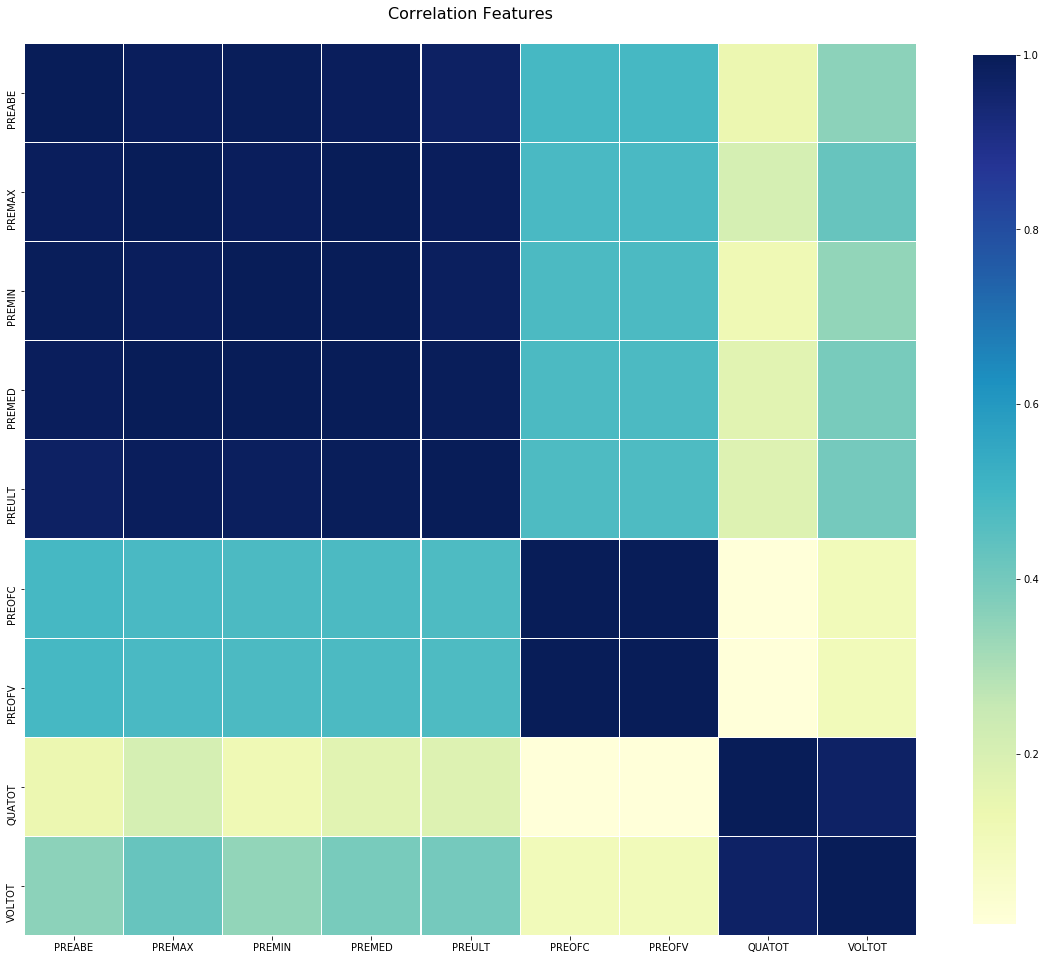

In [56]:
# Cria um heatmap correlation 
def corr_heatmap(df):
    
    plt.subplots(figsize =(20, 20))
    
    sns.heatmap(
        df.corr(), 
        cmap = 'YlGnBu',
        square=True, 
        cbar_kws={'shrink':.8 },
        linewidths=0.1,vmax=1.0
    )
    
    plt.title('Correlation Features', y=1.02, size=16)

    
corr_heatmap(df_v2)

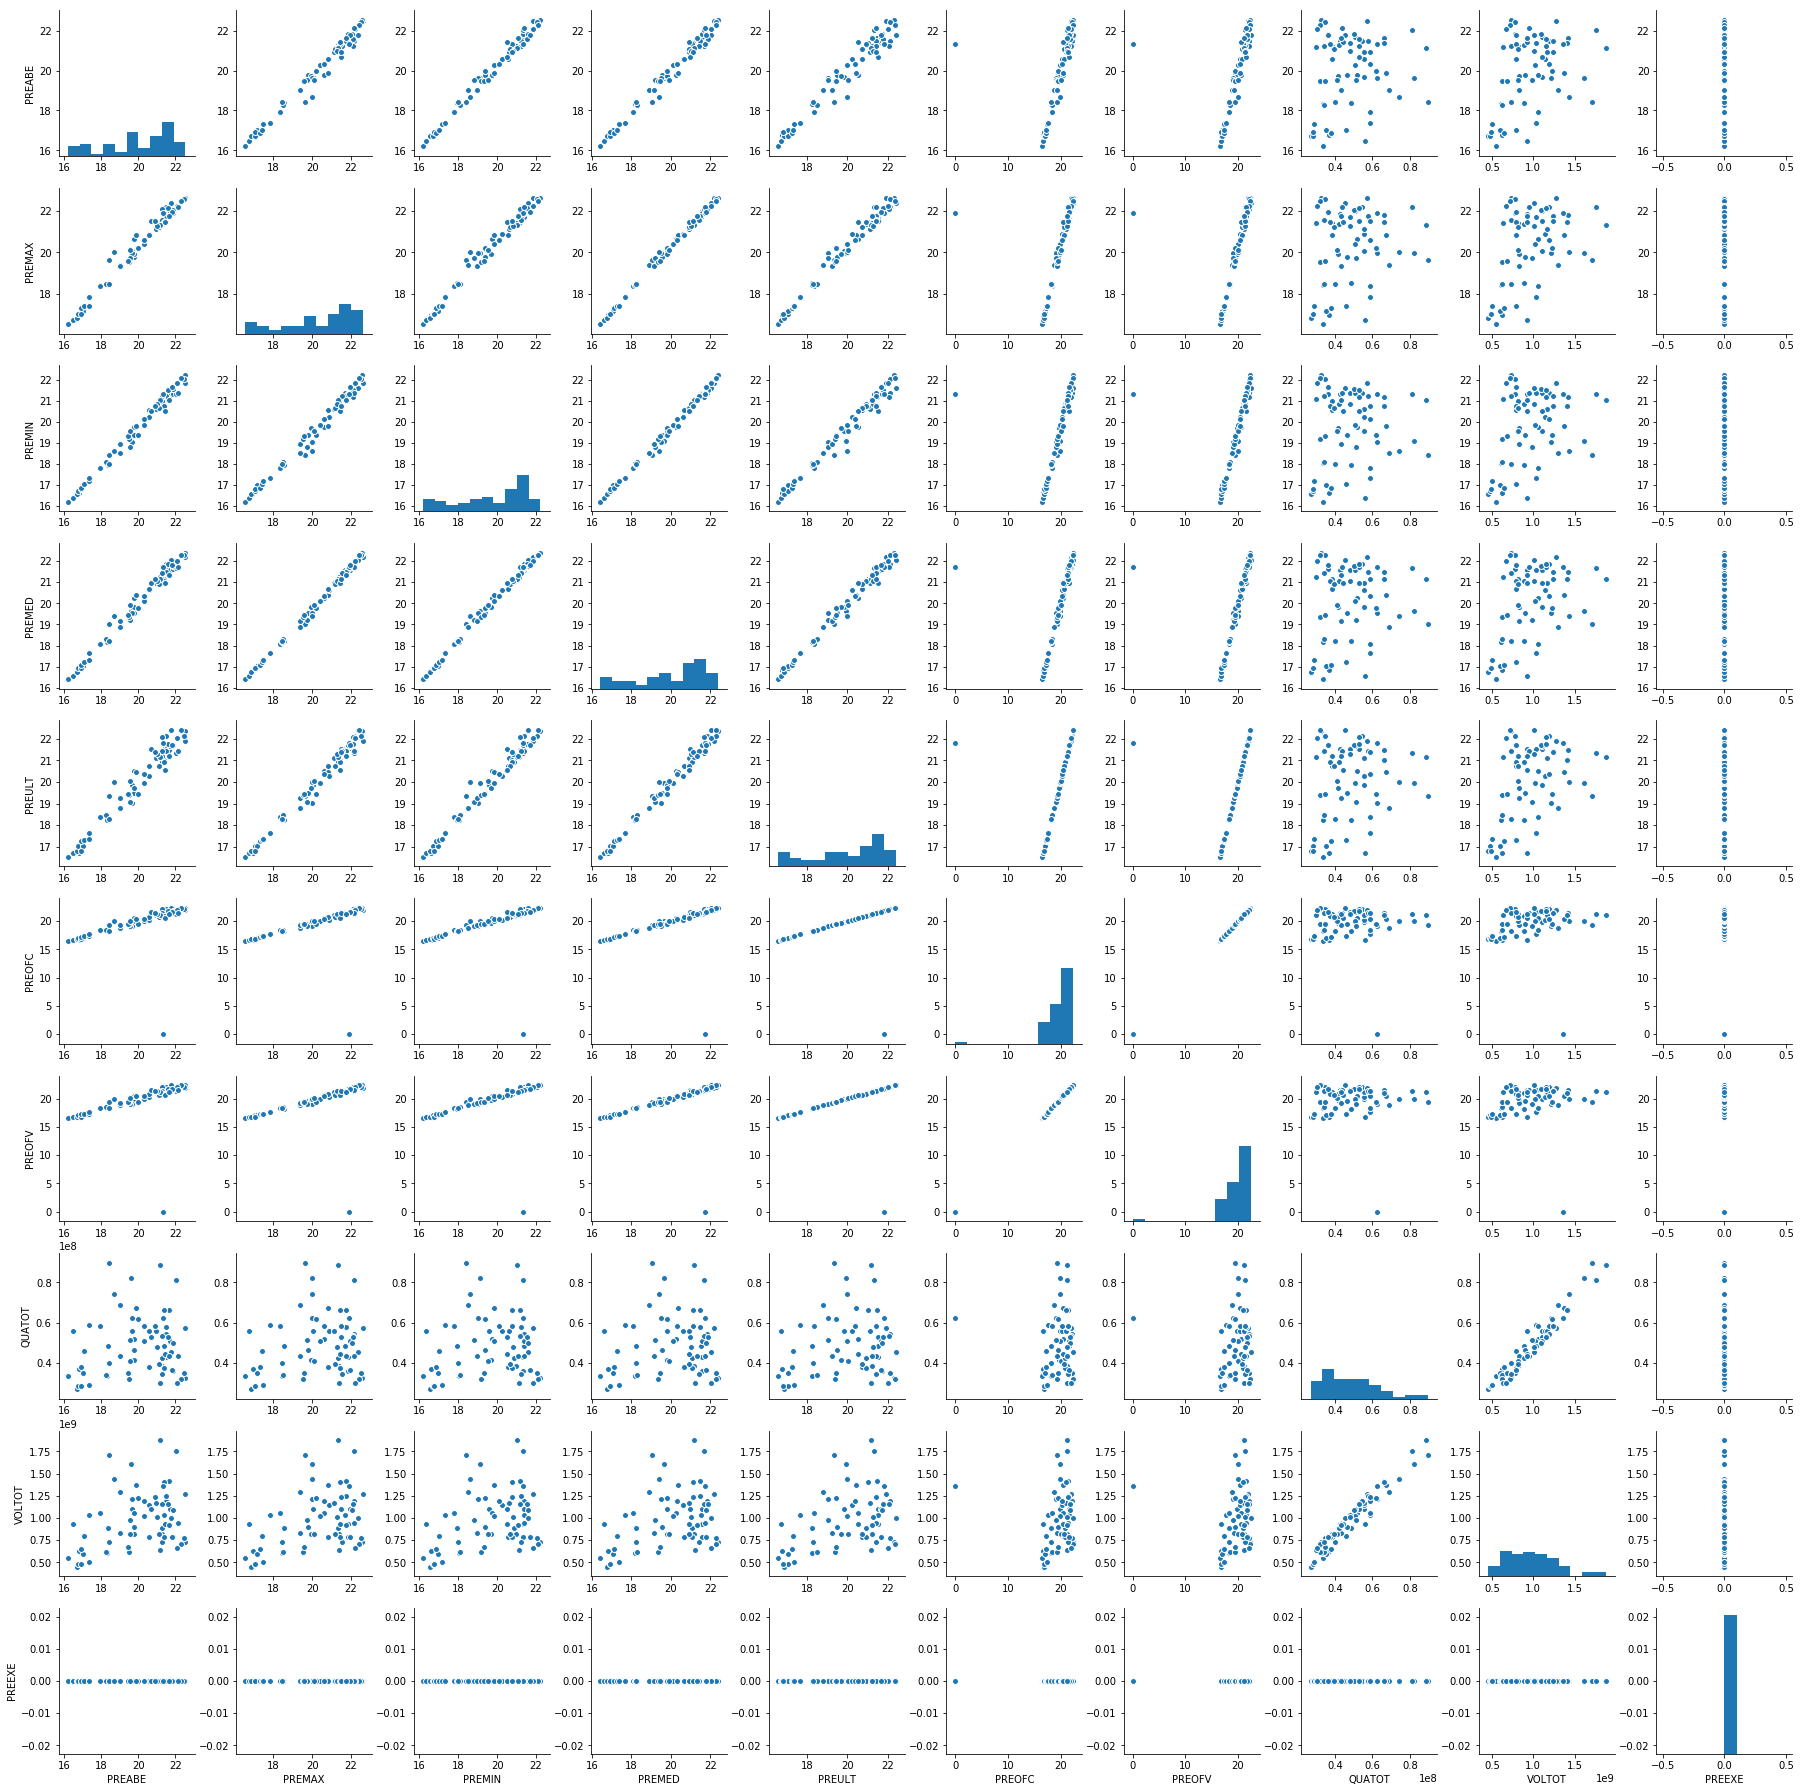

In [24]:
# Pairplot
sns.pairplot(df_v2)

In [57]:
# Separando as Features e Target

X = df_v2.drop('PREULT', axis=1)
y = df_v2['PREULT']

# Esse comando adiciona os valores dos coefientes à variável X (o bias será calculado internamente pela função)
X1 = sm.add_constant(X)

In [58]:
# Print resumo estatístico

modelo_v1 = sm.OLS(y, X1)
modelo_v2 = modelo_v1.fit()
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PREULT   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1185.
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           6.60e-64
Time:                        19:09:27   Log-Likelihood:                 39.810
No. Observations:                  70   AIC:                            -61.62
Df Residuals:                      61   BIC:                            -41.38
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0338      0.731     -0.046      0.963      -1.495       1.428
PREABE        -0.6273      0.109     -5.766      0.000      -0.845      -0.410
PREMAX         0.2317      0.305      0.761      0.450      -0.378       0.841
PREMIN         0.0869      0.314      0.277      0.783      -0.540       0.714
PREMED         1.3046      0.521      2.504      0.015       0.263       2.346
PREOFC         1.8876      1.539      1.226      0.225      -1.190       4.965
PREOFV        -1.8791      1.538     -1.222      0.226      -4.954       1.196
QUATOT      1.294e-09   1.69e-08      0.077      0.939   -3.25e-08    3.51e-08
VOLTOT     -1.303e-10   8.31e-10     -0.157      0.876   -1.79e-09    1.53e-09
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.057
Skew:                           0.066   Prob(JB):                        0.972
Kurtosis:                       2.959   Cond. No.                     1.28e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# Criando o modelo

model = linear_model.LinearRegression(normalize=False, fit_intercept=True)

In [69]:
# Analisando a importância dos atributos 

model.fit(X,y)
for coef, var in sorted(zip(map(abs, model.coef_), X.columns[:]), reverse = True):
    print ("%6.3f %s" % (coef,var))

 1.888 PREOFC
 1.879 PREOFV
 1.305 PREMED
 0.627 PREABE
 0.232 PREMAX
 0.087 PREMIN
 0.000 QUATOT
 0.000 VOLTOT


In [75]:
# Colocando os dados em escala. 

standardization = StandardScaler()
Stand_coef_linear_reg = make_pipeline(standardization, model)

In [76]:
# Reanalisando a importância após o processo de colocar em escala os dados. 

Stand_coef_linear_reg.fit(X,y)
for coef, var in sorted(zip(map(abs, Stand_coef_linear_reg.steps[1][1].coef_), X.columns[:]), reverse = True):
    print ("%6.3f %s" % (coef,var))

 5.519 PREOFC
 5.498 PREOFV
 2.260 PREMED
 1.123 PREABE
 0.411 PREMAX
 0.149 PREMIN
 0.041 VOLTOT
 0.019 QUATOT


In [79]:
# Analisando o R Squared

def r2_est(X,y):
    return r2_score(y, Stand_coef_linear_reg.fit(X,y).predict(X))

print ('Baseline R2: %0.3f' %  r2_est(X,y))

Baseline R2: 0.994


In [81]:
# Gera o impacto de cada atributo no R2
r2_impact = list()
for j in range(X.shape[1]):
    selection = [i for i in range(X.shape[1]) if i!=j]
    r2_impact.append(((r2_est(X,y) - r2_est(X.values[:,selection],y)), X.columns[j]))
    
for imp, varname in sorted(r2_impact, reverse = True):
    print ('%6.3f %s' %  (imp, varname))

 0.003 PREABE
 0.001 PREMED
 0.000 PREOFC
 0.000 PREOFV
 0.000 PREMAX
 0.000 PREMIN
 0.000 VOLTOT
 0.000 QUATOT
